In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

# loading scripts from here
from eval_link_prediction import accuracy, precision, recall
from link_prediction import negative_sampling, balanced_samples

Using matplotlib backend: agg


# GNN

In [2]:
class NaiveConv(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(NaiveConv, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(in_channel, out_channel),
            torch.nn.Tanh()
        )
        
    def forward(self, x, adj):
        h = self.layers(x)
        x = torch.mm(
            adj,
            h
        )
        return x

class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Net, self).__init__()
        
        self.conv1 = NaiveConv(in_channel, 16)
        self.conv2 = NaiveConv(16, out_channel)
        
        # predict exists or not
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channel, 50),
            torch.nn.ELU(),
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, data, query_index):
        x, adj = data.x, data.adj
        
        emb = self.conv1(x, adj)
        emb = F.dropout(emb, training=self.training)
        emb = self.conv2(emb, adj)
        
        # get queried embeddings
        emb_query = torch.cat((emb[query_index[0]], emb[query_index[1]]), dim=1)
        
        # using embeddings to get score out
        score = self.layers(emb_query)
        
        return score

# Compile Model

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
tolerance = 1.00

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)
data = dataset.data

# compile model
in_dim = dataset.num_node_features

model = Net(
    in_dim,
    50
).to(device)

# optimizer
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)

# loss function
criterion = torch.nn.modules.loss.BCELoss()

# Split the Dataset

In [4]:
# random sampling edges
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

# split edges
edges = data.edge_index.detach().cpu().numpy().T
edge_train, edge_test = train_test_split(edges, train_size=train_frac, random_state=42)
edge_val, edge_test = train_test_split(
    edge_test, 
    train_size=val_frac/(test_frac + val_frac), 
    random_state=42
)

# create train, validation, test positive edges
data.edge_train = torch.Tensor(edge_train).long().t()
data.edge_val = torch.Tensor(edge_val).long().t()
data.edge_test = torch.Tensor(edge_test).long().t()
data.y_train = torch.ones(len(edge_train), 1).long().t()
data.y_val = torch.ones(len(edge_val), 1).long().t()
data.y_test = torch.ones(len(edge_test), 1).long().t()

# create adjacency matrix
data.adj = to_dense_adj(add_self_loops(data.edge_train)[0])[0]

# to device (GPU default)
data = dataset.data.to(device)

# record the 
num_nodes = data.x.shape[0]
num_edges = data.edge_index.shape[1]
num_train = len(data.edge_train.t())
num_val = len(data.edge_val.t())
num_test = len(data.edge_test.t())

print('Number of nodes =', num_nodes)
print('Number of edges =', num_edges)
print('Training edges =', num_train)
print('Validation edges =', num_val)
print('Test edges =', num_test)

Number of nodes = 2708
Number of edges = 10556
Training edges = 8444
Validation edges = 1056
Test edges = 1056


# Training

In [5]:
# record accuracy
train_loss = np.zeros(NUMEPOCHS)
val_loss = np.zeros(NUMEPOCHS)
test_loss = np.zeros(NUMEPOCHS)

# negative sampling
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)

# training start
for epoch in range(NUMEPOCHS):
    # negative sampling
    edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
    edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
    
    model.train()
    optimizer.zero_grad()
    out = model(data, edge_train)
    loss = criterion(out, y_train.float())
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_loss[epoch] = loss.item()
    model.eval()
    val_loss[epoch] = criterion(model(data, edge_val), y_val.float()).item()
    test_loss[epoch] = criterion(model(data, edge_test), y_test.float()).item()

    if epoch % 500 == 0:
        print(
            epoch, 
            ', train loss =', loss.item(),
            ', val loss =', val_loss[epoch], 
        )

0 , train loss = 0.6598463654518127 , val loss = 0.6690473556518555
500 , train loss = 0.2509179413318634 , val loss = 0.37358272075653076
1000 , train loss = 0.18765856325626373 , val loss = 0.37854433059692383
1500 , train loss = 0.16283637285232544 , val loss = 0.34609174728393555
2000 , train loss = 0.15485785901546478 , val loss = 0.35877731442451477
2500 , train loss = 0.14747263491153717 , val loss = 0.36282628774642944
3000 , train loss = 0.1373908668756485 , val loss = 0.366836816072464
3500 , train loss = 0.1368926763534546 , val loss = 0.3550829589366913
4000 , train loss = 0.12906737625598907 , val loss = 0.3843947649002075
4500 , train loss = 0.12783369421958923 , val loss = 0.3772751986980438
5000 , train loss = 0.11964055895805359 , val loss = 0.34249255061149597
5500 , train loss = 0.10968100279569626 , val loss = 0.3674163222312927
6000 , train loss = 0.10673218220472336 , val loss = 0.3423699736595154
6500 , train loss = 0.11399969458580017 , val loss = 0.367278337478

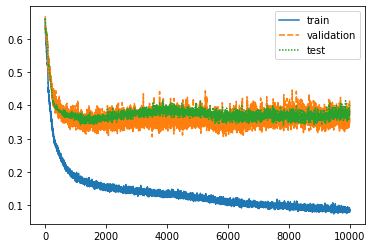

In [6]:
df_acc = pd.DataFrame({
    'train': train_loss,
    'validation': val_loss,
    'test': test_loss
})

sns.lineplot(data=df_acc)
plt.show()

In [7]:
edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)

train_score = model(data, edge_train).detach().cpu().numpy().ravel()
val_score = model(data, edge_val).detach().cpu().numpy().ravel()
test_score = model(data, edge_test).detach().cpu().numpy().ravel()

train_pred = (train_score > 0.5).astype(np.int8)
val_pred = (val_score > 0.5).astype(np.int8)
test_pred = (test_score > 0.5).astype(np.int8)

print('Train Accuracy: {:.4f}'.format(accuracy(train_pred, y_train)))
print('Validation Accuracy: {:.4f}'.format(accuracy(val_pred, y_val)))
print('Test Accuracy: {:.4f}'.format(accuracy(test_pred, y_test)))

print('Train Precision: {:.4f}'.format(precision(train_pred, y_train)))
print('Validation Precision: {:.4f}'.format(precision(val_pred, y_val)))
print('Test Precision: {:.4f}'.format(precision(test_pred, y_test)))

print('Train Recall: {:.4f}'.format(recall(train_pred, y_train)))
print('Validation Recall: {:.4f}'.format(recall(val_pred, y_val)))
print('Test Recall: {:.4f}'.format(recall(test_pred, y_test)))

Train Accuracy: 0.9831
Validation Accuracy: 0.9058
Test Accuracy: 0.8873
Train Precision: 0.9686
Validation Precision: 0.9735
Test Precision: 0.9606
Train Recall: 0.9986
Validation Recall: 0.8343
Test Recall: 0.8078


In [3]:
test_acc_all = np.array([0.8812, 0.8807, 0.8968, 0.8897, 0.8873])
test_precision_all = np.array([0.9517, 0.9507, 0.9761, 0.9567, 0.9606])
test_recall_all = np.array([0.8030, 0.8030, 0.8134, 0.8163, 0.8078])

print(np.mean(test_acc_all))
print(np.mean(test_precision_all))
print(np.mean(test_recall_all))

print(np.std(test_acc_all))
print(np.std(test_precision_all))
print(np.mean(test_recall_all))

0.8871399999999999
0.95916
0.8087
0.005943938088506655
0.00919034275748189
0.8087


In [6]:
print('$%.2f\pm%.2f$' % (np.mean(test_acc_all) * 100, np.std(test_acc_all) * 100))
print('$%.2f\pm%.2f$' % (np.mean(test_precision_all) * 100, np.std(test_precision_all) * 100))
print('$%.2f\pm%.2f$' % (np.mean(test_recall_all) * 100, np.std(test_recall_all) * 100))

$88.71\pm0.59$
$95.92\pm0.92$
$80.87\pm0.54$
